In [1]:
!pip install awswrangler

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.5/394.5 kB 20.3 MB/s eta 0:00:00


# Installing and importing packages and reading in the data

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
import awswrangler as wr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 500)

In [3]:
df = wr.s3.read_csv('s3://dsp-data-vq22301/dataset_drop_md.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/awswrangler/s3/_read_text_core.py:112: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df: pd.DataFrame = parser_func(f, **pandas_kwargs)


# Setting up Variables...

In [4]:
glossary = {
    'CAPEI': {'Ratio': 'Shillers Cyclically Adjusted P/E Ratio', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to 5-year moving average of Net Income'},
    'bm': {'Ratio': 'Book/Market', 'Category': 'Valuation', 'Formula': 'Book Value of Equity as a fraction of Market Value of Equity'},
    'evm': {'Ratio': 'Enterprise Value Multiple', 'Category': 'Valuation', 'Formula': 'Multiple of Enterprise Value to EBITDA'},
    'pe_op_basic': {'Ratio': 'Price/Operating Earnings (Basic, Excl. EI)', 'Category': 'Valuation', 'Formula': 'Price to Operating EPS, excl. Extraordinary Items (Basic)'},
    'pe_op_dil': {'Ratio': 'Price/Operating Earnings (Diluted, Excl. EI)', 'Category': 'Valuation', 'Formula': 'Price to Operating EPS, excl. Extraordinary Items (Diluted)'},
    'pe_exi': {'Ratio': 'P/E (Diluted, Excl. EI)', 'Category': 'Valuation', 'Formula': 'Price-to-Earnings, excl. Extraordinary Items (diluted)'},
    'pe_inc': {'Ratio': 'P/E (Diluted, Incl. EI)', 'Category': 'Valuation', 'Formula': 'Price-to-Earnings, incl. Extraordinary Items (diluted)'},
    'ps': {'Ratio': 'Price/Sales', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to Sales'},
    'pcf': {'Ratio': 'Price/Cash flow', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to Net Cash Flow from Operating Activities'},
    'dpr': {'Ratio': 'Dividend Payout Ratio', 'Category': 'Valuation', 'Formula': 'Dividends as a fraction of Income Before Extra. Items'},
    'npm': {'Ratio': 'Net Profit Margin', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of Sales'},
    'opmbd': {'Ratio': 'Operating Profit Margin Before Depreciation', 'Category': 'Profitability', 'Formula': 'Operating Income Before Depreciation as a fraction of Sales'},
    'opmad': {'Ratio': 'Operating Profit Margin After Depreciation', 'Category': 'Profitability', 'Formula': 'Operating Income After Depreciation as a fraction of Sales'},
    'gpm': {'Ratio': 'Gross Profit Margin', 'Category': 'Profitability', 'Formula': 'Gross Profit as a fraction of Sales'},
    'ptpm': {'Ratio': 'Pre-tax Profit Margin', 'Category': 'Profitability', 'Formula': 'Pretax Income as a fraction of Sales'},
    'cfm': {'Ratio': 'Cash Flow Margin', 'Category': 'Financial Soundness', 'Formula': 'Income before Extraordinary Items and Depreciation as a fraction of Sales'},
    'roa': {'Ratio': 'Return on Assets', 'Category': 'Profitability', 'Formula': 'Operating Income Before Depreciation as a fraction of average TotalAssets based on most recent two periods'},
    'roe': {'Ratio': 'Return on Equity', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of average Book Equity based on most recent two periods, where Book Equity is defined as the sum of Total Parent Stockholders Equity and Deferred Taxes and Investment Tax Credit'},
    'roce': {'Ratio': 'Return on Capital Employed', 'Category': 'Profitability', 'Formula': 'Earnings Before Interest and Taxes as a fraction of average Capital Employed based on most recent two periods, where Capital Employed is the sum of Debt in Long-term and Current Liabilities and Common/Ordinary Equity'},
    'efftax': {'Ratio': 'Effective Tax Rate', 'Category': 'Profitability', 'Formula': 'Income Tax as a fraction of Pretax Income'},
    'aftret_eq': {'Ratio': 'After-tax Return on Average Common Equity', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of average of Common Equity based on most recent two periods'},
    'aftret_invcapx': {'Ratio': 'After-tax Return on Invested Capital', 'Category': 'Profitability', 'Formula': 'Net Income plus Interest Expenses as a fraction of Invested Capital'},
    'aftret_equity': {'Ratio': 'After-tax Return on Total Stockholders’ Equity', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of average of Total Shareholders’ Equity based on most recent two periods'},
    'pretret_noa': {'Ratio': 'Pre-tax return on Net Operating Assets', 'Category': 'Profitability', 'Formula': 'Operating Income After Depreciation as a fraction of average Net Operating Assets (NOA) based on most recent two periods, where NOA is defined as the sum of Property Plant and Equipment and Current Assets minus Current Liabilities'},
    'pretret_earnat': {'Ratio': 'Pre-tax Return on Total Earning Assets', 'Category': 'Profitability', 'Formula': 'Operating Income After Depreciation as a fraction of average Total Earnings Assets (TEA) based on most recent two periods, where TEA is defined as the sum of Property Plant and Equipment and Current Assets'},
    'GProf': {'Ratio': 'Gross Profit/Total Assets', 'Category': 'Profitability', 'Formula': 'Gross Profitability as a fraction of Total Assets'},
    'equity_invcap': {'Ratio': 'Common Equity/Invested Capital', 'Category': 'Capitalisation', 'Formula': 'Common Equity as a fraction of Invested Capital'},
    'debt_invcap': {'Ratio': 'Long-term Debt/Invested Capital', 'Category': 'Capitalisation', 'Formula': 'Long-term Debt as a fraction of Invested Capital'},
    'totdebt_invcap': {'Ratio': 'Total Debt/Invested Capital', 'Category': 'Capitalisation', 'Formula': 'Total Debt (Long-term and Current) as a fraction of Invested Capital'},
    'capital_ratio': {'Ratio': 'Capitalization Ratio', 'Category': 'Capitalisation', 'Formula': 'Total Long-term Debt as a fraction of the sum of Total Long-term Debt, Common/Ordinary Equity and Preferred Stock'},
    'int_debt': {'Ratio': 'Interest/Average Long-term Debt', 'Category': 'Financial Soundness', 'Formula': 'Interest as a fraction of average Long-term debt based on most recent two periods'},
    'int_totdebt': {'Ratio': 'Interest/Average Total Debt', 'Category': 'Financial Soundness', 'Formula': 'Interest as a fraction of average Total Debt based on most recent two periods'},
    'cash_lt': {'Ratio': 'Cash Balance/Total Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Cash Balance as a fraction of Total Liabilities'},
    'invt_act': {'Ratio': 'Inventory/Current Assets', 'Category': 'Financial Soundness', 'Formula': 'Inventories as a fraction of Current Assets'},
    'rect_act': {'Ratio': 'Receivables/Current Assets', 'Category': 'Financial Soundness', 'Formula': 'Accounts Receivables as a fraction of Current Assets'},
    'debt_at': {'Ratio': 'Total Debt/Total Assets', 'Category': 'Solvency', 'Formula': 'Total Liabilities as a fraction of Total Assets'},
    'debt_ebitda': {'Ratio': 'debt_ebitda', 'Category': 'Financial Soundness', 'Formula': 'Gross Debt as a fraction of EBITDA'},
    'short_debt': {'Ratio': 'Short-Term Debt/Total Debt', 'Category': 'Financial Soundness', 'Formula': 'Short-term Debt as a fraction of Total Debt'},
    'curr_debt': {'Ratio': 'Current Liabilities/Total Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Current Liabilities as a fraction of Total Liabilities'},
    'lt_debt': {'Ratio': 'Long-term Debt/Total Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Long-term Debt as a fraction of Total Liabilities'},
    'profit_lct': {'Ratio': 'Profit Before Depreciation/Current Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Operating Income before D&A as a fraction of Current Liabilities'},
    'ocf_lct': {'Ratio': 'Operating CF/Current Liabilities', 'Category': 'Financial Soundess', 'Formula': 'Operating Cash Flow as a fraction of Current Liabilities'},
    'cash_debt': {'Ratio': 'Cash Flow/Total Debt', 'Category': 'Financial Soundness', 'Formula': 'Operating Cash Flow as a fraction of Total Debt'},
    'fcf_ocf': {'Ratio': 'Free Cash Flow/Operating Cash Flow', 'Category': 'Financial Soundness', 'Formula': 'Free Cash Flow as a fraction of Operating Cash Flow, where Free Cash Flow is defined as the difference between Operating Cash Flow and Capital Expenditures'},
    'lt_ppent': {'Ratio': 'Total Liabilities/Total Tangible Assets', 'Category': 'Financial Soundness', 'Formula': 'Total Liabilities to Total Tangible Assets'},
    'dltt_be': {'Ratio': 'Long-term Debt/Book Equity', 'Category': 'Financial Soundess', 'Formula': 'Long-term Debt to Book Equity'},
    'debt_assets': {'Ratio': 'Total Debt/Total Assets', 'Category': 'Solvency', 'Formula': 'Total Debt as a fraction of Total Assets'},
    'debt_capital': {'Ratio': 'Total Debt/Capital', 'Category': 'Solvency', 'Formula': 'Total Debt as a fraction of Total Capital, where Total Debt is defined as the sum of Accounts Payable and Total Debt in Current and Long-term Liabilities, and Total Capital is defined as the sum of Total Debt and Total Equity (common and preferred)'},
    'de_ratio': {'Ratio': 'Total Debt/Equity', 'Category': 'Solvency', 'Formula': 'Total Liabilities to Shareholders’ Equity (common and preferred)'},
    'intcov': {'Ratio': 'After-tax Interest Coverage', 'Category': 'Solvency', 'Formula': 'Multiple of After-tax Income to Interest and Related Expenses'},
    'intcov_ratio': {'Ratio': 'Interest Coverage Ratio', 'Category': 'Solvency', 'Formula': 'Multiple of Earnings Before Interest and Taxes to Interest and Related Expenses'},
    'cash_ratio': {'Ratio': 'Cash Ratio', 'Category': 'Liquidity', 'Formula': 'Cash and Short-term Investments as a fraction of Current Liabilities'},
    'quick_ratio': {'Ratio': 'Quick Ratio (Acid Test)', 'Category': 'Liquidity', 'Formula': 'Quick Ratio: Current Assets net of Inventories as a fraction of Current Liabilities'},
    'curr_ratio': {'Ratio': 'Current Ratio', 'Category': 'Liquidity', 'Formula': 'Current Assets as a fraction of Current Liabilities'},
    'cash_conversion': {'Ratio': 'Cash Conversion Cycle (Days)', 'Category': 'Liquidity', 'Formula': 'Inventories per daily COGS plus Account Receivables per daily Sales minus Account Payables per daily COGS'},
    'inv_turn': {'Ratio': 'Inventory Turnover', 'Category': 'Efficiency', 'Formula': 'COGS as a fraction of the average Inventories based on the most recent two periods'},
    'at_turn': {'Ratio': 'Asset Turnover', 'Category': 'Efficiency', 'Formula': 'Sales as a fraction of the average Total Assets based on the most recent two periods'},
    'rect_turn': {'Ratio': 'Receivables Turnover', 'Category': 'Efficiency', 'Formula': 'Sales as a fraction of the average of Accounts Receivables based on the most recent two periods'},
    'pay_turn': {'Ratio': 'Payables Turnover', 'Category': 'Efficiency', 'Formula': 'COGS and change in Inventories as a fraction of the average of Accounts Payable based on the most recent two periods'},
    'sale_invcap': {'Ratio': 'Sales/Invested Capital', 'Category': 'Efficiency', 'Formula': 'Sales per dollar of Invested Capital'},
    'sale_equity': {'Ratio': 'Sales/Stockholders Equity', 'Category': 'Efficiency', 'Formula': 'Sales per dollar of total Stockholders’ Equity'},
    'sale_nwc': {'Ratio': 'Sales/Working Capital', 'Category': 'Efficiency', 'Formula': 'Sales per dollar of Working Capital, defined as difference between Current Assets and Current Liabilities'},
    'rd_sale': {'Ratio': 'Research and Development/Sales', 'Category': 'Other', 'Formula': 'R&D expenses as a fraction of Sales'},
    'adv_sale': {'Ratio': 'Avertising Expenses/Sales', 'Category': 'Other', 'Formula': 'Advertising Expenses as a fraction of Sales'},
    'staff_sale': {'Ratio': 'Labor Expenses/Sales', 'Category': 'Other', 'Formula': 'Labor Expenses as a fraction of Sales'},
    'accrual': {'Ratio': 'Accruals/Average Assets', 'Category': 'Other', 'Formula': 'Accruals as a fraction of average Total Assets based on most recent two periods'},
    'ptb': {'Ratio': 'Price/Book', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to Book Value of Equity'},
    'PEG_trailing': {'Ratio': 'Trailing P/E to Growth (PEG) ratio', 'Category': 'Valuation', 'Formula': 'Price-to-Earnings, excl. Extraordinary Items (diluted) to 3-Year past EPS Growth'},
    'divyield': {'Ratio': 'Dividend Yield', 'Category': 'Valuation', 'Formula': 'Indicated Dividend Rate as a fraction of Price'}
}

inputs = ['CAPEI', 'bm',
       'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
       'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
       'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt',
       'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct',
       'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets',
       'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing',
       'divyield', 'MthCap', 'FEDFUNDS', '1yr_inf_rate', '1mo_inf_rate', '1yr_GDP', '1mo_GDP', 'DGS10']

target = '1yr_return'

# Cleaning and Data Preparation

## 1) Drop NaN values

The random forest model does not handle missing data well. Therefore, we will drop the columns with too many NaN values as they are less likely to be useful to the model and it will help us avoid dropping too many instances and therefore losing valuable information. Most of these are trailing ratios or lesser known variants.

In [5]:
df_inputs_with_names = df[inputs].copy()

In [6]:
for col in df_inputs_with_names.columns:
    try:
        df_inputs_with_names = df_inputs_with_names.rename(columns={col: f'{col} - ' + f'{glossary[col]["Ratio"]} - ' + f'{glossary[col]["Category"]}'.upper()})
    except:
        pass

In [7]:
df_inputs_with_names.isnull().sum()

CAPEI - Shillers Cyclically Adjusted P/E Ratio - VALUATION                            289560
bm - Book/Market - VALUATION                                                          102700
evm - Enterprise Value Multiple - VALUATION                                            71675
pe_op_basic - Price/Operating Earnings (Basic, Excl. EI) - VALUATION                  857977
pe_op_dil - Price/Operating Earnings (Diluted, Excl. EI) - VALUATION                 1447613
pe_exi - P/E (Diluted, Excl. EI) - VALUATION                                          236473
pe_inc - P/E (Diluted, Incl. EI) - VALUATION                                          238219
ps - Price/Sales - VALUATION                                                           92783
pcf - Price/Cash flow - VALUATION                                                      93162
dpr - Dividend Payout Ratio - VALUATION                                               652628
npm - Net Profit Margin - PROFITABILITY                               

In [8]:
cols_to_drop = []
cols_to_keep = []

for i, value in enumerate(df_inputs_with_names.isnull().sum()):
    if value > 120000:
        cols_to_drop.append(df[inputs].columns[i])
    else:
        cols_to_keep.append(df[inputs].columns[i])

In [9]:
print(len(df[cols_to_keep]), len(cols_to_drop), len(df[cols_to_keep].dropna(how='any')))

2498891 35 2224385


## 2) Date formatting and sorting

Let's also format dates correctly and sort the df by gvkey and public_date in ascending order.

In [10]:
df['public_date'] = pd.to_datetime(df['public_date'])
df = df.sort_values(by='public_date', ascending=True)
print(df.loc[0, 'public_date'], df.loc[len(df)-1, 'public_date'])

1971-02-28 00:00:00 2021-12-31 00:00:00


In [11]:
df = df.sort_values(by=['gvkey', 'public_date'], ascending=True)

# Grid Search with Cross Validation for Optimal Model Hyperparameters

Let's use grid search on the two important hyperparameters for RF, maximum depth and number of tree estimators. Let's first select a bootstrap sample of 10% of the full dataset to use to reduce the computational complexity of the task. Due to the sheer size of our total dataset (2.5m instances), this is unlikely to affect performance in any way.

In [12]:
df = df.reset_index(drop=True)
X = df[cols_to_keep].dropna().sample(frac=0.1, replace=True, random_state=777)  # take a bootstrap sample to decrease training time
y = df['1yr_return'].loc[X.index]
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

Let's use 5-fold cross validation as well to ensure robustness of our results.

In [22]:
performance = [[[] for _ in range(11)] for _ in range(5)]
kf = KFold(5, shuffle=True, random_state=777)

for i, (train_index, val_index) in enumerate(kf.split(X)):
    
    Xtr, ytr = X.loc[train_index, :], y.loc[train_index]
    Xval, yval = X.loc[val_index,:], y.loc[val_index]
    
    for j, max_depth in enumerate(range(3, 14, 1)):
        
        for k, n_estimators in enumerate(range(50, 375, 25)):
            
            rf = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, max_samples=0.1, max_features='sqrt', random_state=777)
            rf.fit(Xtr.to_numpy(), ytr.to_numpy())
            yval_pred = rf.predict(Xval.to_numpy())
            mse = mean_squared_error(yval, yval_pred)
            performance[i][j].append(mse)
            print(f'DONE: Fold {i}, Max Depth: {max_depth}, n_estimators: {n_estimators}, MSE: {mse}')

DONE: Fold 0, Max Depth: 3, n_estimators: 50, MSE: 1.61767288020688
DONE: Fold 0, Max Depth: 3, n_estimators: 75, MSE: 1.5831145569007794
DONE: Fold 0, Max Depth: 3, n_estimators: 100, MSE: 1.5881575024845251
DONE: Fold 0, Max Depth: 3, n_estimators: 125, MSE: 1.5915909152469365
DONE: Fold 0, Max Depth: 3, n_estimators: 150, MSE: 1.593017404540306
DONE: Fold 0, Max Depth: 3, n_estimators: 175, MSE: 1.5897957972914565
DONE: Fold 0, Max Depth: 3, n_estimators: 200, MSE: 1.580884415648029
DONE: Fold 0, Max Depth: 3, n_estimators: 225, MSE: 1.5829748476365701
DONE: Fold 0, Max Depth: 3, n_estimators: 250, MSE: 1.5849523334433337
DONE: Fold 0, Max Depth: 3, n_estimators: 275, MSE: 1.5865600589486961
DONE: Fold 0, Max Depth: 3, n_estimators: 300, MSE: 1.5831654770271355
DONE: Fold 0, Max Depth: 3, n_estimators: 325, MSE: 1.579711374325547
DONE: Fold 0, Max Depth: 3, n_estimators: 350, MSE: 1.5806766759364752
DONE: Fold 0, Max Depth: 4, n_estimators: 50, MSE: 1.6049037959057628
DONE: Fold 0, 

DONE: Fold 0, Max Depth: 11, n_estimators: 350, MSE: 1.4940525369752067
DONE: Fold 0, Max Depth: 12, n_estimators: 50, MSE: 1.5457838901835987
DONE: Fold 0, Max Depth: 12, n_estimators: 75, MSE: 1.508834094458697
DONE: Fold 0, Max Depth: 12, n_estimators: 100, MSE: 1.5135681585708722
DONE: Fold 0, Max Depth: 12, n_estimators: 125, MSE: 1.5180121414844354
DONE: Fold 0, Max Depth: 12, n_estimators: 150, MSE: 1.5171502271860204
DONE: Fold 0, Max Depth: 12, n_estimators: 175, MSE: 1.5165680449607228
DONE: Fold 0, Max Depth: 12, n_estimators: 200, MSE: 1.5075247416707904
DONE: Fold 0, Max Depth: 12, n_estimators: 225, MSE: 1.5069331074525958
DONE: Fold 0, Max Depth: 12, n_estimators: 250, MSE: 1.5068674728409435
DONE: Fold 0, Max Depth: 12, n_estimators: 275, MSE: 1.507160879214442
DONE: Fold 0, Max Depth: 12, n_estimators: 300, MSE: 1.4986271478556288
DONE: Fold 0, Max Depth: 12, n_estimators: 325, MSE: 1.4945812824871294
DONE: Fold 0, Max Depth: 12, n_estimators: 350, MSE: 1.4969130833402

DONE: Fold 1, Max Depth: 9, n_estimators: 325, MSE: 1.7885849706319936
DONE: Fold 1, Max Depth: 9, n_estimators: 350, MSE: 1.7870338075211827
DONE: Fold 1, Max Depth: 10, n_estimators: 50, MSE: 1.7974315861648744
DONE: Fold 1, Max Depth: 10, n_estimators: 75, MSE: 1.7905413374020798
DONE: Fold 1, Max Depth: 10, n_estimators: 100, MSE: 1.787765025632142
DONE: Fold 1, Max Depth: 10, n_estimators: 125, MSE: 1.7824949957688105
DONE: Fold 1, Max Depth: 10, n_estimators: 150, MSE: 1.7717826563790837
DONE: Fold 1, Max Depth: 10, n_estimators: 175, MSE: 1.7702235674882647
DONE: Fold 1, Max Depth: 10, n_estimators: 200, MSE: 1.7731109166130028
DONE: Fold 1, Max Depth: 10, n_estimators: 225, MSE: 1.7725409141229633
DONE: Fold 1, Max Depth: 10, n_estimators: 250, MSE: 1.7709592247434274
DONE: Fold 1, Max Depth: 10, n_estimators: 275, MSE: 1.7700432150173957
DONE: Fold 1, Max Depth: 10, n_estimators: 300, MSE: 1.769583646678996
DONE: Fold 1, Max Depth: 10, n_estimators: 325, MSE: 1.770056128783335

DONE: Fold 2, Max Depth: 7, n_estimators: 300, MSE: 1.1903473558901252
DONE: Fold 2, Max Depth: 7, n_estimators: 325, MSE: 1.190749226064107
DONE: Fold 2, Max Depth: 7, n_estimators: 350, MSE: 1.1909205955290423
DONE: Fold 2, Max Depth: 8, n_estimators: 50, MSE: 1.209517131578194
DONE: Fold 2, Max Depth: 8, n_estimators: 75, MSE: 1.2037399107383648
DONE: Fold 2, Max Depth: 8, n_estimators: 100, MSE: 1.1929444539132814
DONE: Fold 2, Max Depth: 8, n_estimators: 125, MSE: 1.1925868316734527
DONE: Fold 2, Max Depth: 8, n_estimators: 150, MSE: 1.1941236615531412
DONE: Fold 2, Max Depth: 8, n_estimators: 175, MSE: 1.1921424735934214
DONE: Fold 2, Max Depth: 8, n_estimators: 200, MSE: 1.1902728307845627
DONE: Fold 2, Max Depth: 8, n_estimators: 225, MSE: 1.1893327048609517
DONE: Fold 2, Max Depth: 8, n_estimators: 250, MSE: 1.1872075843260665
DONE: Fold 2, Max Depth: 8, n_estimators: 275, MSE: 1.1840019335396361
DONE: Fold 2, Max Depth: 8, n_estimators: 300, MSE: 1.1824182265636611
DONE: Fold

DONE: Fold 3, Max Depth: 5, n_estimators: 275, MSE: 1.6987681779560209
DONE: Fold 3, Max Depth: 5, n_estimators: 300, MSE: 1.699160810641796
DONE: Fold 3, Max Depth: 5, n_estimators: 325, MSE: 1.6991832632638826
DONE: Fold 3, Max Depth: 5, n_estimators: 350, MSE: 1.700294938365514
DONE: Fold 3, Max Depth: 6, n_estimators: 50, MSE: 1.709905312456102
DONE: Fold 3, Max Depth: 6, n_estimators: 75, MSE: 1.6965809160899314
DONE: Fold 3, Max Depth: 6, n_estimators: 100, MSE: 1.6975025026862811
DONE: Fold 3, Max Depth: 6, n_estimators: 125, MSE: 1.6950331564994112
DONE: Fold 3, Max Depth: 6, n_estimators: 150, MSE: 1.6922878997371067
DONE: Fold 3, Max Depth: 6, n_estimators: 175, MSE: 1.6923339884310131
DONE: Fold 3, Max Depth: 6, n_estimators: 200, MSE: 1.6870139734629603
DONE: Fold 3, Max Depth: 6, n_estimators: 225, MSE: 1.6847666091878573
DONE: Fold 3, Max Depth: 6, n_estimators: 250, MSE: 1.6840295293962229
DONE: Fold 3, Max Depth: 6, n_estimators: 275, MSE: 1.6845698342706876
DONE: Fold 

DONE: Fold 4, Max Depth: 3, n_estimators: 250, MSE: 3.049139156707104
DONE: Fold 4, Max Depth: 3, n_estimators: 275, MSE: 3.047796530797818
DONE: Fold 4, Max Depth: 3, n_estimators: 300, MSE: 3.049299639382412
DONE: Fold 4, Max Depth: 3, n_estimators: 325, MSE: 3.045547542306398
DONE: Fold 4, Max Depth: 3, n_estimators: 350, MSE: 3.047057697350607
DONE: Fold 4, Max Depth: 4, n_estimators: 50, MSE: 3.0343163753181943
DONE: Fold 4, Max Depth: 4, n_estimators: 75, MSE: 3.030530006185467
DONE: Fold 4, Max Depth: 4, n_estimators: 100, MSE: 3.035021291468973
DONE: Fold 4, Max Depth: 4, n_estimators: 125, MSE: 3.025752572380553
DONE: Fold 4, Max Depth: 4, n_estimators: 150, MSE: 3.023812404029921
DONE: Fold 4, Max Depth: 4, n_estimators: 175, MSE: 3.023236417262783
DONE: Fold 4, Max Depth: 4, n_estimators: 200, MSE: 3.024697756307264
DONE: Fold 4, Max Depth: 4, n_estimators: 225, MSE: 3.025470200218082
DONE: Fold 4, Max Depth: 4, n_estimators: 250, MSE: 3.027165553020342
DONE: Fold 4, Max Dep

DONE: Fold 4, Max Depth: 12, n_estimators: 250, MSE: 2.944447174032876
DONE: Fold 4, Max Depth: 12, n_estimators: 275, MSE: 2.9416943265566826
DONE: Fold 4, Max Depth: 12, n_estimators: 300, MSE: 2.9456587598582207
DONE: Fold 4, Max Depth: 12, n_estimators: 325, MSE: 2.9420734804712647
DONE: Fold 4, Max Depth: 12, n_estimators: 350, MSE: 2.9417592777078942
DONE: Fold 4, Max Depth: 13, n_estimators: 50, MSE: 2.976528774862489
DONE: Fold 4, Max Depth: 13, n_estimators: 75, MSE: 2.9545348358763777
DONE: Fold 4, Max Depth: 13, n_estimators: 100, MSE: 2.957309435634534
DONE: Fold 4, Max Depth: 13, n_estimators: 125, MSE: 2.9456022999690052
DONE: Fold 4, Max Depth: 13, n_estimators: 150, MSE: 2.9416300848915147
DONE: Fold 4, Max Depth: 13, n_estimators: 175, MSE: 2.9433587646130537
DONE: Fold 4, Max Depth: 13, n_estimators: 200, MSE: 2.944429388175253
DONE: Fold 4, Max Depth: 13, n_estimators: 225, MSE: 2.939468789671197
DONE: Fold 4, Max Depth: 13, n_estimators: 250, MSE: 2.946536464922452


In [34]:
performance_means = []

for j in range(len(performance[0])):
    for k in range(len(performance[0][0])):
        performance_means.append(np.mean([performance[i][j][k] for i in range(len(performance))]))

best_setup = [1000, []]
for i, max_depth in enumerate(range(3, 14, 1)):
    for j, n_estimators in enumerate(range(50, 375, 25)):
        print(f'Max Depth = {max_depth} - n_estimators = {n_estimators} - Performance = {performance_means[(i*len(range(50, 375, 25))) + j]}')
        if performance_means[(i*len(range(50, 375, 25))) + j] < best_setup[0]:
              best_setup = [performance_means[(i*len(range(50, 375, 25))) + j], [max_depth, n_estimators]]

print(f'BEST SETUP:\nMax depth = {best_setup[1][0]}\nn_estimators = {best_setup[1][1]}')

Max Depth = 3 - n_estimators = 50 - Performance = 1.9127761841343414
Max Depth = 3 - n_estimators = 75 - Performance = 1.9024596631787385
Max Depth = 3 - n_estimators = 100 - Performance = 1.9012829388994952
Max Depth = 3 - n_estimators = 125 - Performance = 1.9008671073881391
Max Depth = 3 - n_estimators = 150 - Performance = 1.8994248612576587
Max Depth = 3 - n_estimators = 175 - Performance = 1.899450888298538
Max Depth = 3 - n_estimators = 200 - Performance = 1.8977849928285813
Max Depth = 3 - n_estimators = 225 - Performance = 1.8982723623556474
Max Depth = 3 - n_estimators = 250 - Performance = 1.898287603053389
Max Depth = 3 - n_estimators = 275 - Performance = 1.898116172431139
Max Depth = 3 - n_estimators = 300 - Performance = 1.8976042285859767
Max Depth = 3 - n_estimators = 325 - Performance = 1.8962499414299459
Max Depth = 3 - n_estimators = 350 - Performance = 1.8962318423662405
Max Depth = 4 - n_estimators = 50 - Performance = 1.9012158362273393
Max Depth = 4 - n_estimato

Text(0.5, 1.0, 'Hyperparameter Optimisation Results')

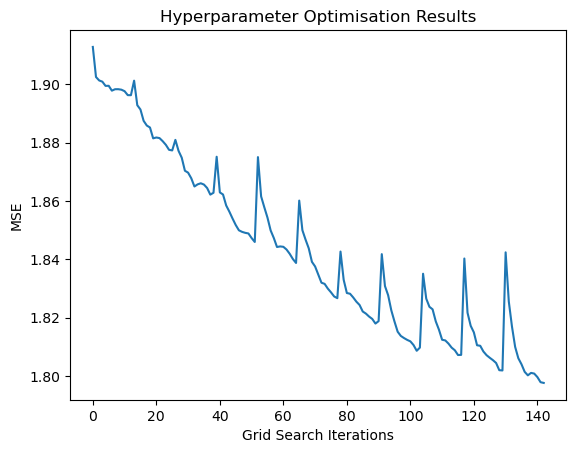

In [39]:
plt.plot(performance_means)
plt.ylabel('MSE')
plt.xlabel('Grid Search Iterations')
plt.title('Hyperparameter Optimisation Results')

It appears that gains for both `max_depth` and `n_estimators` begin to tail off after our upper limits on both in the grid search. We could try higher thresholds but in favour of minimising model complexity and in review of the miniscule gains in MSE, we will assume that the optimal model in our case has `max_depth` = 13 and `n_estimators` = 350.

# Model Simulation

Now let's run the model and induce on the data for each trading year, using an expanding window stretching back to 1971 as the training data. The window is constructed so as to avoid any lookahead bias. We need a minimum of approx. 10 years for our model to be fairly judged. Therefore, we will start testing the model from `1981-12-31` onwards.

We will store the results in individual csv files in our S3 bucket to be accessed later when evaluating results and constructing our LSTM (with the most important RF features).

In [75]:
sequence_start_year = '1971-12-31'

def get_portfolio_return(y_actual, y_pred, num_stocks=30):
    return np.mean(y_actual[y_pred.argsort()[-num_stocks:].tolist()])

def run_model(df=df, sequence_start_year='1971-12-31', allow_caps=['Nano Cap', 'Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap', 'Mega Cap']):
    
    for year in range(1981, 2022):

        test_results = pd.DataFrame(columns=['prediction_yr', 'ret_mkt_avg', 'ret_30', 'ret_50', 'ret_100', 'ret_150', 'ret_200', 'mse', 'top_features', 'feature_importances_raw'])

        prediction_yr = f'{year}-12-31'
        train_end_yr = f'{int(prediction_yr[:4]) - 1}-12-31'
        
        if allow_caps == ['Nano Cap', 'Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap', 'Mega Cap']:
            df_train = df[df['public_date'].between(pd.to_datetime(sequence_start_year), pd.to_datetime(train_end_yr), inclusive='both')]
        else:
            df_train = df[np.logical_and(df.cap.isin(allow_caps), df['public_date'].between(pd.to_datetime(sequence_start_year), pd.to_datetime(train_end_yr), inclusive='both'))]
        Xtr = df_train[cols_to_keep].dropna(how='any')
        ytr = df_train[target].loc[Xtr.index]
        Xtr, ytr = Xtr.reset_index(drop=True), ytr.reset_index(drop=True)
        
        if allow_caps == ['Nano Cap', 'Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap', 'Mega Cap']:
            df_test = df[df['public_date'] == pd.to_datetime(prediction_yr)]
        else:
            df_test = df[np.logical_and(df.cap.isin(allow_caps), df['public_date'] == pd.to_datetime(prediction_yr))]
        Xtest = df_test[cols_to_keep].dropna(how='any')
        ytest = df_test[target].loc[Xtest.index]
        Xtest, ytest = Xtest.reset_index(drop=True), ytest.reset_index(drop=True)

        rf = RandomForestRegressor(max_depth=13, n_estimators=350, max_samples=0.1, max_features='sqrt', random_state=777)
        rf.fit(Xtr.to_numpy(), ytr.to_numpy())
        ytest_pred = rf.predict(Xtest.to_numpy())
        test_results.loc[0, 'prediction_yr'] = prediction_yr
        test_results.loc[0, 'ret_mkt_avg'] = np.mean(ytest)
        for num_stocks in [30, 50, 100, 150, 200]:
            test_results.loc[0, f'ret_{num_stocks}'] = get_portfolio_return(ytest, ytest_pred, num_stocks)
        test_results.loc[0, 'mse'] = mean_squared_error(ytest, ytest_pred)
        test_results.loc[0, 'top_features'] = np.array(cols_to_keep)[rf.feature_importances_.argsort().tolist()]
        test_results.loc[0, 'feature_importances_raw'] = np.sort(rf.feature_importances_)
        raw_test_output = pd.DataFrame({'ytest_pred_raw': ytest_pred})
        if allow_caps == ['Nano Cap', 'Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap', 'Mega Cap']:
            wr.s3.to_csv(df=test_results, path=f's3://dsp-data-vq22301/rf_test_results/rf_results_{year}.csv', index=False)
            wr.s3.to_csv(df=raw_test_output, path=f's3://dsp-data-vq22301/rf_test_results/rf_results_{year}_raw.csv', index=False)
        else:
            wr.s3.to_csv(df=test_results, path=f's3://dsp-data-vq22301/rf_test_results/cap_limit_results/rf_results_{allow_caps[0][:2]}_{year}.csv', index=False)
            wr.s3.to_csv(df=raw_test_output, path=f's3://dsp-data-vq22301/rf_test_results/cap_limit_results/rf_results_{allow_caps[0][:2]}_{year}_raw.csv', index=False)
            
        print(f'DONE: {year}, Market Avg: {np.mean(ytest)}, Top 30 results: {get_portfolio_return(ytest, ytest_pred, 30)}')

First, we will run it with no cap limit.

In [ ]:
run_model(df=df,
         sequence_start_year='1971-12-31',
         )

Now, let's run it with the cap limit

In [76]:
run_model(df=df,
         sequence_start_year='1971-12-31',
          allow_caps=['Mid Cap', 'Large Cap', 'Mega Cap']
         )

DONE: 1981, Market Avg: 0.14690847693196235, Top 30 results: 0.31619970126944197
DONE: 1982, Market Avg: 0.08248593765725265, Top 30 results: 0.4007478845005743
DONE: 1983, Market Avg: -0.11533213858790411, Top 30 results: -0.23882392405246353
DONE: 1984, Market Avg: 0.17409657539197487, Top 30 results: 0.20275329127309816
DONE: 1985, Market Avg: -0.047670705382531355, Top 30 results: -0.09063416182796354
DONE: 1986, Market Avg: -0.14972201831548443, Top 30 results: -0.12039853847719542
DONE: 1987, Market Avg: 0.12243439980878552, Top 30 results: 0.24379034509855865
DONE: 1988, Market Avg: 0.11425367302910099, Top 30 results: 0.023388793434055526
DONE: 1989, Market Avg: -0.20446157336539092, Top 30 results: -0.3931550156171541
DONE: 1990, Market Avg: 0.3190448314090328, Top 30 results: 0.4876777250349467
DONE: 1991, Market Avg: 0.03426128955427139, Top 30 results: 0.16562330634632128
DONE: 1992, Market Avg: 0.05352253308521451, Top 30 results: 0.08993818270770873
DONE: 1993, Market Avg